In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import torch.fft
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
img = Image.open('lena_gray.jpg')
img = img.convert('L')
img = np.array(img)
img = torch.from_numpy(img)
print(img.shape) # (512, 512)

torch.Size([512, 512])


torch.Size([512, 512])


C:\Users\johnk\AppData\Local\Temp\ipykernel_12784\675804309.py:3: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(fft_img)))


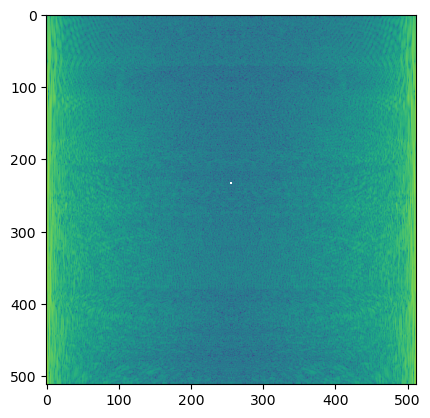

In [22]:
fft_img = torch.fft.fft(img)
print(fft_img.shape)  # torch.Size([512, 512])
plt.imshow(np.log(np.abs(fft_img)))

In [4]:
print(fft_img[0][:5])

tensor([69926.0000+0.0000j,   805.3099+2691.1960j,  -573.3997+96.8765j,
         1643.0288-3832.4575j,  2157.2170-2545.8218j])


In [5]:
def roll_n(X, axis, n):
    f_idx = tuple(slice(None, None, None) 
            if i != axis else slice(0, n, None) 
            for i in range(X.dim()))
    b_idx = tuple(slice(None, None, None) 
            if i != axis else slice(n, None, None) 
            for i in range(X.dim()))
    front = X[f_idx]
    back = X[b_idx]
    return torch.cat([back, front], axis)
def fftshift(X):
    real, imag = X.chunk(chunks=2, dim=-1)
    real, imag = real.squeeze(dim=-1), imag.squeeze(dim=-1)
    for dim in range(2, len(real.size())):
        real = roll_n(real, axis=dim, 
                      n=int(np.ceil(real.size(dim) / 2)))
        imag = roll_n(imag, axis=dim, 
                      n=int(np.ceil(imag.size(dim) / 2)))
    real, imag = real.unsqueeze(dim=-1), imag.unsqueeze(dim=-1)
    X = torch.cat((real,imag),dim=1)
    return torch.squeeze(X)
def ifftshift(X):
    real, imag = X.chunk(chunks=2, dim=-1)
    real, imag = real.squeeze(dim=-1), imag.squeeze(dim=-1)
    
    for dim in range(len(real.size()) - 1, 1, -1):
        real = roll_n(real, axis=dim, 
                      n=int(np.floor(real.size(dim) / 2)))
        imag = roll_n(imag, axis=dim, 
                      n=int(np.floor(imag.size(dim) / 2)))
    real, imag = real.unsqueeze(dim=-1), imag.unsqueeze(dim=-1)
    X = torch.cat((real, imag), dim=1)
    return torch.squeeze(X)

### Apply the high pass filter

In [18]:
fft_shift_img = fftshift(fft_img)
filter_rate   = 0.85
h, w          = fft_shift_img.shape[:2] # height and width
cy, cx        = int(h/2), int(w/2) # centerness
rh, rw        = int(filter_rate * cy), int(filter_rate * cx) # filter_size

# the value of center pixel is zero.
fft_shift_img[cy-rh:cy+rh, cx-rw:cx+rw] = 0

In [19]:
# restore the frequency image
ifft_shift_img = ifftshift(fft_shift_img)

# inverce fft
ifft_img = torch.fft.ifft(ifft_shift_img)

C:\Users\johnk\AppData\Local\Temp\ipykernel_12784\169431181.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ifft_img = ifft_img.real.astype(np.int)


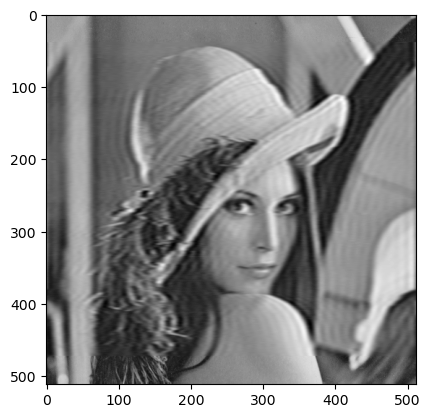

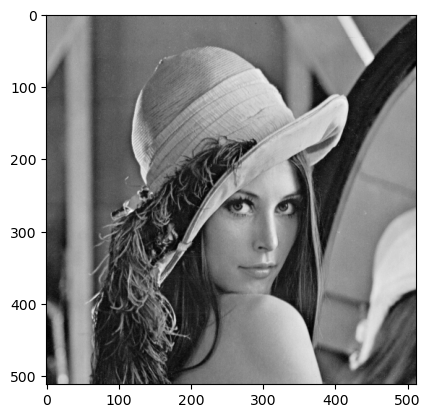

In [20]:
ifft_img = ifft_img.to('cpu').detach().numpy().copy()
ifft_img = ifft_img.real.astype(np.int)
plt.imshow(ifft_img, cmap='gray')
plt.show()

plt.imshow(img, cmap='gray')
plt.show()